In [1]:
import torchaudio
from transformers import WavLMModel
import torch
import glob
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

/home/nacho/muiarfid/rah_projects/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load wavlm model

In [2]:
model = WavLMModel.from_pretrained("patrickvonplaten/wavlm-libri-clean-100h-base-plus")
model.to('cuda:0' if torch.cuda.is_available() else 'cpu')

print(model.feature_extractor)
print(model.feature_projection)
print(model.encoder)

# print number of parameters
print('number of parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

/home/nacho/muiarfid/rah_projects/.venv/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of WavLMModel were not initialized from the model checkpoint at patrickvonplaten/wavlm-libri-clean-100h-base-plus and are newly initialized: ['wavlm.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wavlm.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


WavLMFeatureEncoder(
  (conv_layers): ModuleList(
    (0): WavLMGroupNormConvLayer(
      (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      (activation): GELUActivation()
      (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
    )
    (1-4): 4 x WavLMNoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (5-6): 2 x WavLMNoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
  )
)
WavLMFeatureProjection(
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (projection): Linear(in_features=512, out_features=768, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
WavLMEncoder(
  (pos_conv_embed): WavLMPositionalConvEmbedding(
    (conv): ParametrizedConv1d(
      768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
      (parametrizations): ModuleDi

# Test feature extractor and model output (encoder)

In [3]:
x = torch.randn(1, 16000)
x = x.to('cuda:0' if torch.cuda.is_available() else 'cpu')

f = model.feature_extractor(x)
print(f.shape)

o = model(x)
print(model.feature_extractor)
y = o.last_hidden_state
print(y.shape)

# torch.onnx.export(model.feature_extractor, x, "feature_extractor.onnx")

torch.Size([1, 512, 49])
WavLMFeatureEncoder(
  (conv_layers): ModuleList(
    (0): WavLMGroupNormConvLayer(
      (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      (activation): GELUActivation()
      (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
    )
    (1-4): 4 x WavLMNoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (5-6): 2 x WavLMNoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
  )
)
torch.Size([1, 49, 768])


# Embeddings from feature extractor

In [4]:
def embeddings(pattern):
    files_ = glob.glob(pattern)
    e = []
    for wav in sorted(files_):
        x, fs = torchaudio.load(wav)
        x = x.to('cuda:0' if torch.cuda.is_available() else 'cpu')
        with torch.no_grad():
            f = model.feature_extractor(x)
            e.append(f.mean(2).cpu())
            del f
        del x
        torch.cuda.empty_cache()
    
    return torch.cat(e).detach().numpy()

## Embeddings from feature extractor: gender

(200, 512) (300, 512)


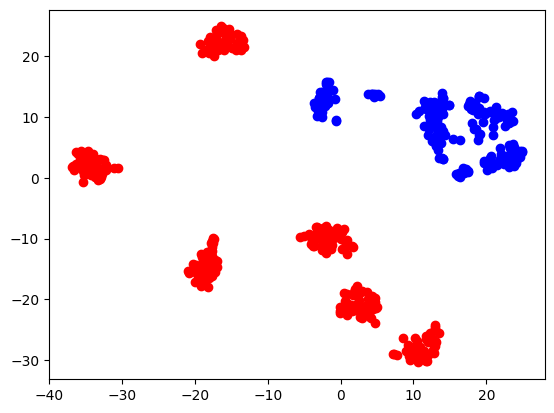

In [5]:
e1 = embeddings('datasets/data1/test/*m*2.wav')
e2 = embeddings('datasets/data1/test/*f*2.wav')
e = np.concatenate([e1,e2])
print(e1.shape, e2.shape)
et = TSNE(n_components=2).fit_transform(e)
plt.clf()
plt.scatter(et[:len(e1),0], et[:len(e1),1], c='b')
plt.scatter(et[len(e1):,0], et[len(e1):,1], c='r')

## Embeddings from feature extractor: speaker

(50, 512) (50, 512) (50, 512) (50, 512)


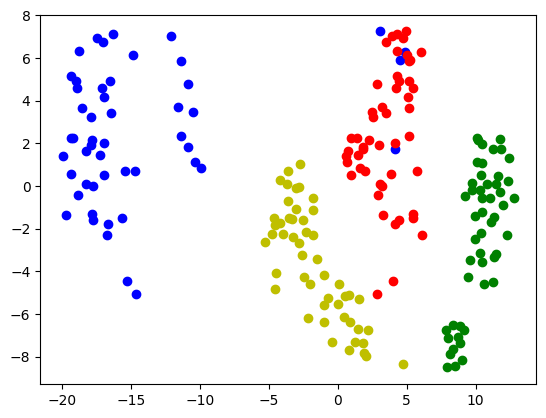

In [6]:
e1 = embeddings('datasets/data1/test/*m_51_2.wav')
e2 = embeddings('datasets/data1/test/*m_53_2.wav')
e3 = embeddings('datasets/data1/test/*m_54_2.wav')
e4 = embeddings('datasets/data1/test/*m_55_2.wav')

e = np.concatenate([e1,e2,e3,e4])
l = np.concatenate([np.zeros(len(e1)), np.ones(len(e2)), np.ones(len(e3))*2, np.ones(len(e4))*3])
print(e1.shape, e2.shape, e3.shape, e4.shape)
et = TSNE(n_components=2).fit_transform(e)
plt.clf()
plt.scatter(et[l==0,0], et[l==1,1], c='b')
plt.scatter(et[l==1,0], et[l==1,1], c='r')
plt.scatter(et[l==2,0], et[l==2,1], c='g')
plt.scatter(et[l==3,0], et[l==3,1], c='y')

## Embeddings from feature extractor: word

(50, 512) (50, 512) (50, 512) (50, 512)


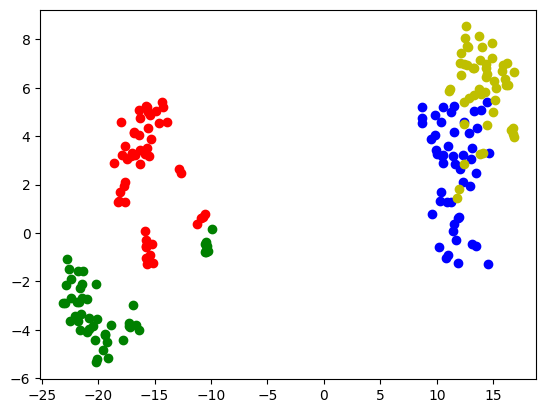

In [7]:
e1 = embeddings('datasets/data1/test/*m_51_1.wav')
e2 = embeddings('datasets/data1/test/*m_51_2.wav')
e3 = embeddings('datasets/data1/test/*m_51_3.wav')
e4 = embeddings('datasets/data1/test/*m_51_4.wav')

e = np.concatenate([e1,e2,e3,e4])
l = np.concatenate([np.zeros(len(e1)), np.ones(len(e2)), np.ones(len(e3))*2, np.ones(len(e4))*3])

print(e1.shape, e2.shape, e3.shape, e4.shape)
et = TSNE(n_components=2).fit_transform(e)
plt.clf()
plt.scatter(et[l==0,0], et[l==1,1], c='b')
plt.scatter(et[l==1,0], et[l==1,1], c='r')
plt.scatter(et[l==2,0], et[l==2,1], c='g')
plt.scatter(et[l==3,0], et[l==3,1], c='y')

# Embeddings from model output (encoder)

In [8]:
def embeddings2(pattern):
    files_ = glob.glob(pattern)
    e = []
    for wav in sorted(files_):
        x, fs = torchaudio.load(wav)
        x = x.to('cuda:0' if torch.cuda.is_available() else 'cpu')
        with torch.no_grad():
            o = model(x).last_hidden_state
            e.append( o.mean(1).cpu() )
            del o
        x.cpu()
        del x
        torch.cuda.empty_cache()
    return torch.cat(e).detach().numpy()

# Embeddings from model output (encoder): gender

(200, 768) (300, 768)


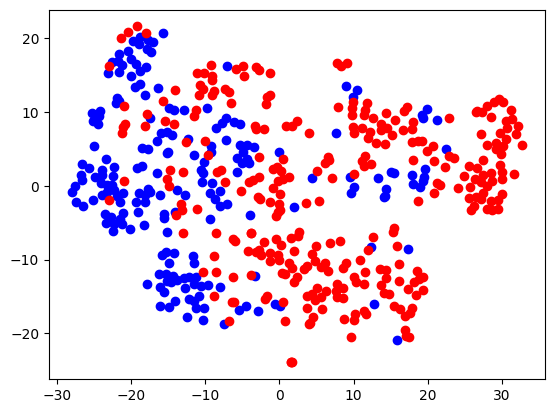

In [9]:
e1 = embeddings2('datasets/data1/test/*m*2.wav')
e2 = embeddings2('datasets/data1/test/*f*2.wav')
e = np.concatenate([e1,e2])
print(e1.shape, e2.shape)
et = TSNE(n_components=2).fit_transform(e)
plt.clf()
plt.scatter(et[:len(e1),0], et[:len(e1),1], c='b')
plt.scatter(et[len(e1):,0], et[len(e1):,1], c='r')

# Embeddings from model output (encoder): speaker

(50, 768) (50, 768) (50, 768) (50, 768)


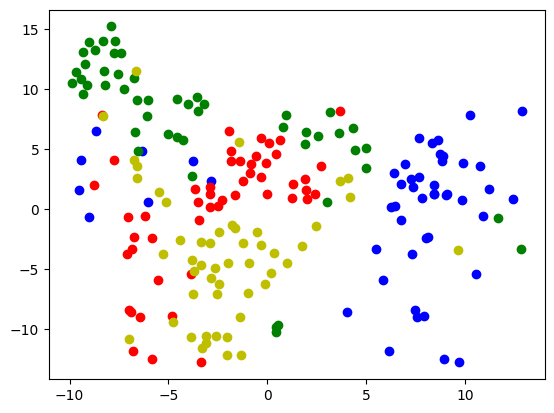

In [11]:
e1 = embeddings2('datasets/data1/test/*m_51_2.wav')
e2 = embeddings2('datasets/data1/test/*m_53_2.wav')
e3 = embeddings2('datasets/data1/test/*m_54_2.wav')
e4 = embeddings2('datasets/data1/test/*m_55_2.wav')

e = np.concatenate([e1,e2,e3,e4])
l = np.concatenate([np.zeros(len(e1)), np.ones(len(e2)), np.ones(len(e3))*2, np.ones(len(e4))*3])
print(e1.shape, e2.shape, e3.shape, e4.shape)
et = TSNE(n_components=2).fit_transform(e)
plt.clf()
plt.scatter(et[l==0,0], et[l==1,1], c='b')
plt.scatter(et[l==1,0], et[l==1,1], c='r')
plt.scatter(et[l==2,0], et[l==2,1], c='g')
plt.scatter(et[l==3,0], et[l==3,1], c='y')

# Embeddings from model output (encoder): word

(50, 768) (50, 768) (50, 768) (50, 768)


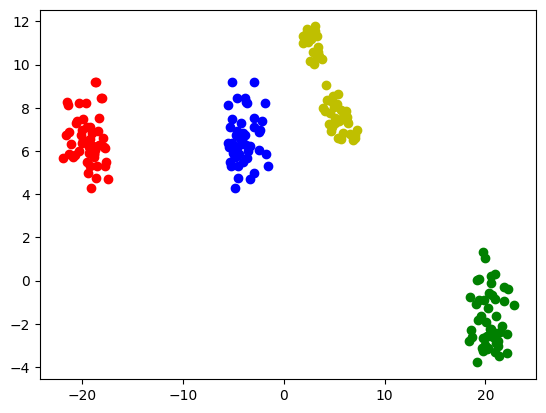

In [12]:
e1 = embeddings2('datasets/data1/test/*m_51_1.wav')
e2 = embeddings2('datasets/data1/test/*m_51_2.wav')
e3 = embeddings2('datasets/data1/test/*m_51_3.wav')
e4 = embeddings2('datasets/data1/test/*m_51_4.wav')

e = np.concatenate([e1,e2,e3,e4])
l = np.concatenate([np.zeros(len(e1)), np.ones(len(e2)), np.ones(len(e3))*2, np.ones(len(e4))*3])

print(e1.shape, e2.shape, e3.shape, e4.shape)
et = TSNE(n_components=2).fit_transform(e)
plt.clf()
plt.scatter(et[l==0,0], et[l==1,1], c='b')
plt.scatter(et[l==1,0], et[l==1,1], c='r')
plt.scatter(et[l==2,0], et[l==2,1], c='g')
plt.scatter(et[l==3,0], et[l==3,1], c='y')